In [2]:
from sklearn import preprocessing
from itertools import chain
import logging
import gzip
import string
from nltk.corpus import stopwords

import numpy as np
import tensorflow as tf
import re
import nltk
import sys
from collections import OrderedDict
from sklearn.manifold import TSNE # used to reduce demonsionality of word embeddings to shape 1, 2 for graphing
import matplotlib.pyplot as plt


    
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s : %(levelname)s : %(message)s",
    handlers=[
        logging.FileHandler("Z:/ProjectCourse/complete.log"),
        logging.StreamHandler(sys.stdout)
    ]
)

stop_words = set(stopwords.words('english')) | {" ", ""}
%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

## Import Text and Process it

In [18]:
digit_regex = re.compile(rb"^[1-9][0-9]*\t")
def read_input(input_file):
    """This method reads the input file which is in gzip format"""
    input_size = 0
    logging.info("reading file {0}...this may take a while".format(input_file))
    with gzip.open(input_file, 'rb') as f:
        for i, line in enumerate(f):

            if (input_size == 3300000):
                logging.info("Reached desired inpute size of 3300000")
                break

            if (i % 100000 == 0):
                logging.info("read {0} abstracts".format(i))
            

            if len(re.sub(digit_regex, rb"", line)) == 1:
                continue
            
            input_size += 1
            # do some pre-processing and return list of words for each review
            # text
            yield gensim.utils.simple_preprocess(line)

num_regex = re.compile(r"^[1-9][0-9]*\t")

# Create a dictionary

In [24]:
input_file = "Z:/ProjectCourse/Corpus/id_abstract.gz"
sentences  = list(chain(*read_input(input_file, 400000)))#3300000

2022-11-23 20:49:27,018 : INFO : reading file Z:/ProjectCourse/Corpus/id_abstract.gz...this may take a while
2022-11-23 20:49:35,914 : INFO : read 200000 abstracts
2022-11-23 20:49:39,194 : INFO : read 300000 abstracts
2022-11-23 20:49:42,222 : INFO : read 400000 abstracts
2022-11-23 20:50:01,023 : INFO : Reached desired inpute size of 400000


In [ ]:
# get the vocabulary
words = set()
for sentence in sentences:
    words = words.union(set(sentence))
    
word2int = {}
int2word = {}
vocab_size = len(words) # gives the total number of unique words
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word
    

# Generate training data

In [48]:
# Creates a of word pairs with a window size of 10
# Where up to 10 words before and 10 words after the occurce of the center word
# from our corpus
data = []
WINDOW_SIZE = 10
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] : 
            if nb_word != word:
                data.append([word, nb_word])
                
print(data)

[['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king'], ['the', 'he'], ['the', 'is'], ['the', 'king'], ['king', 'is'], ['king', 'the'], ['the', 'king'], ['the', 'is'], ['king', 'the'], ['king', 'is'], ['king', 'royal'], ['is', 'the'], ['is', 'king'], ['is', 'royal'], ['royal', 'king'], ['royal', 'is'], ['she', 'is'], ['she', 'the'], ['is', 'she'], ['is', 'the'], ['is', 'royal'], ['the', 'she'], ['the', 'is'], ['the', 'royal'], ['the', 'queen'], ['royal', 'is'], ['royal', 'the'], ['royal', 'queen'], ['queen', 'the'], ['queen', 'royal']]


In [ ]:
input_training_data = []
output_training_data = []
temp = []
window_size = 10
for i in range(len(words)):
    f = i - window_size
    end = i + window_size
    selected_word = words[i]
    for j in range(start, i):
        if j >= 0:
            temp.append((selected_word, words[j]))
    for j in range(i + 1, end):
        if j < len(vocab):
            temp.append((selected_word, words[j]))

# creating one hot encodings 
for pair in temp_dict:
    temp_input = np.zeros(len(vocab))
    temp_output = np.zeros(len(vocab))
    
    temp_input[char_to_int[pair[0]]] = 1
    temp_output[char_to_int[pair[1]]] = 1
    
    input_training_data .append(temp_input)
    output_training_data.append(temp_output)

In [ ]:
def train(epochs, input_training_data, output_training_data, batch_size, optimizer, x, y):
    
    nbatches = int(len(input_training_data)/batch_size)
    
    init = tf.global_variables_initializer()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.40)
    sess = tf.Session(config = tf.ConfigProto(gpu_options = gpu_options))
    sess.run(init)
    saver = tf.train.Saver()

    for epoch in range(epochs):
        cost = 0
        for i in range(nbatches-1):
            batch_x = input_training_data[i * batch_size :(i + 1) * batch_size]
            batch_y = output_training_data[i * batch_size :(i + 1) * batch_size]
            _, j = sess.run([optimizer, cost], feed_dict = {x:batch_x, y:batch_y})
            cost += j / nbatches
        logging.info(f"Current epoch: {epoch}, Cost: {cost}")
    return saver.save(sess,'./saved_complete_v2_models/complete.weights')

In [ ]:
embedding_size = 300
learning_rate = 0.025

x = tf.placeholder(tf.float32,shape = (None,len(vocab)))
y = tf.placeholder(tf.float32,shape = (None,len(vocab)))

weight1 = tf.Variable(tf.random_normal([len(vocab), embedding_size]),dtype = tf.float32)
bias1 = tf.Variable(tf.random_normal([embedding_size]), dtype = tf.float32)
weight2 = tf.Variable(tf.random_normal([embedding_size, len(vocab)]), dtype = tf.float32)
bias2 = tf.Variable(tf.random_normal([len(vocab)]), dtype = tf.float32)

hidden_y = tf.matmul(tf.matmul(x,weight11) + bias1,weight2) + bias2

cost = tf.reduce_mean(tf.losses.mean_squared_error(hidden_y,y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

batch_size = 10000
epochs = 10
train(epochs, input_training_data, output_training_data, batch_size, optimizer, x, y)


In [ ]:


embeddings = dict()
for i in vocab:
    temp_a = np.zeros([1,len(vocab)])
    temp_a[0][char_to_int[i]] = 1
    temp_emb = sess.run([_y],feed_dict = {x:temp_a})
    temp_emb = np.array(temp_emb)
    #print(temp_emb.shape)
    embeddings[i] = temp_emb.reshape([len(vocab)])
    #print(embeddings[i].shape)

## Looking at the hidden representations Weight1 and bias1


In [53]:
print(sess.run(weight1))
print('--------------------------')
print(sess.run(bias1))
print('--------------------------')

[[-2.4667048  -1.0390921   0.5201295  -0.42721358  0.33458644]
 [-0.11102659  0.20847504  1.623999   -0.01977071  3.474004  ]
 [ 0.627525   -0.4716701   1.4797018   0.13992879 -0.8566276 ]
 [ 0.6442408  -0.42976695 -0.5576406   0.9899494   1.5625219 ]
 [ 0.5571808  -0.13938767 -1.3208493  -2.4646916  -0.6998081 ]
 [ 0.8087424  -0.55020505  1.6411406   0.12971856 -0.68120277]
 [ 0.6365183  -0.01430083 -1.9740577   0.99436265 -1.2716385 ]]
--------------------------
[ 1.0741833  -0.1815876   0.65087634  0.10639327 -1.0893831 ]
--------------------------


In [54]:
vectors = sess.run(weight1 + bias1)
print(vectors)

[[-1.3925215  -1.2206796   1.1710058  -0.3208203  -0.7547967 ]
 [ 0.96315676  0.02688743  2.2748754   0.08662256  2.384621  ]
 [ 1.7017083  -0.6532577   2.130578    0.24632207 -1.9460107 ]
 [ 1.7184241  -0.6113546   0.09323573  1.0963427   0.4731388 ]
 [ 1.6313641  -0.32097527 -0.66997296 -2.3582983  -1.7891912 ]
 [ 1.8829257  -0.7317927   2.292017    0.23611182 -1.7705859 ]
 [ 1.7107017  -0.19588844 -1.3231814   1.1007559  -2.3610215 ]]


In [55]:
# Getting the representation of a word, i.e., queen
print(vectors[word2int['queen']])

[ 1.7184241  -0.6113546   0.09323573  1.0963427   0.4731388 ]


## Dirty imlpementation for finding the closest vector to a given word using euclidean distance

In [56]:
# should the vectors be normalized before finding closest neighbour
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1    
    query_vector = vectors[word_index]    
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
            return min_index

In [57]:
print('king', '-->', int2word[find_closest(word2int['king'], vectors)])
print('queen', '-->', int2word[find_closest(word2int['queen'], vectors)])
print('royal', '-->', int2word[find_closest(word2int['royal'], vectors)])

king --> royal
queen --> royal
royal --> king


## Plotting the vectors

In [58]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors) 

normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

{'royal', 'king', 'she', 'queen', 'the', 'he', 'is'}
royal 0.89717036
king 0.25030422
she 0.96019673
queen 0.5068005
the -0.9047838
he 0.9838481
is -0.4028841


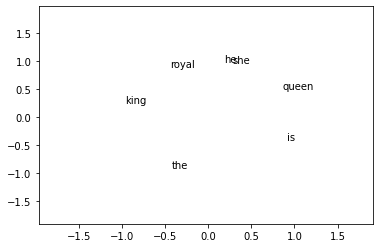

In [59]:
fig, ax = plt.subplots()
print(words)
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
    ax.set_xlim(min([vectors[word2int[w]][0] for w in words])-1, max([vectors[word2int[w]][0] for w in words])+1)
    ax.set_ylim(min([vectors[word2int[w]][1] for w in words])-1, max([vectors[word2int[w]][1] for w in words])+1)
plt.show()